In [2]:
import numpy as np 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['text.usetex'] = True
from scipy.interpolate import interp1d, griddata
#from scipy.interpolate import Akima1DInterpolator
#from scipy.stats import multivariate_normal
import time 
#import corner
#import h5py
#import ipdb
from scipy import integrate 
from tqdm import tqdm
#import os
import pandas as pd
import camb 
from camb import model, initialpower
from CosmologyCalculatorPC import CosmologyCalculatorPC

# Generate $d_L(z)$ using CAMB for $\Lambda CDM$

**Load camb with H0=73, $\mathbf{\Omega_m = 0.24}$ -- same as what I used to produce the PCs**

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Generate $d_L(z)$ using my PCs

In [4]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.

Nx = 1000
zzmin = 0.03
zzmax = 1.7
zBinsFisher = np.array([zzmin + i * (zzmax - zzmin) / Nx for i in range(1, Nx + 1)])
zbins = np.insert(zBinsFisher, 0, 0.03)

alphasfid = np.array([0] * Nx) # When all amplitudes are zero, I get back ΛCDM

eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2_1000PCs_0p03_to_1p7.dat")
#eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2.dat")

eigenvectors.shape

(1000, 1000)

In [5]:
calculator = CosmologyCalculatorPC(73,0.24, 0, alphasfid, eigenvectors)

In [6]:
cambhub = [results.hubble_parameter(z) for z in zBinsFisher]
camblum = [results.luminosity_distance(z) for z in zBinsFisher]

- **Check that $\mathbf{H(z)}$ works as expected**

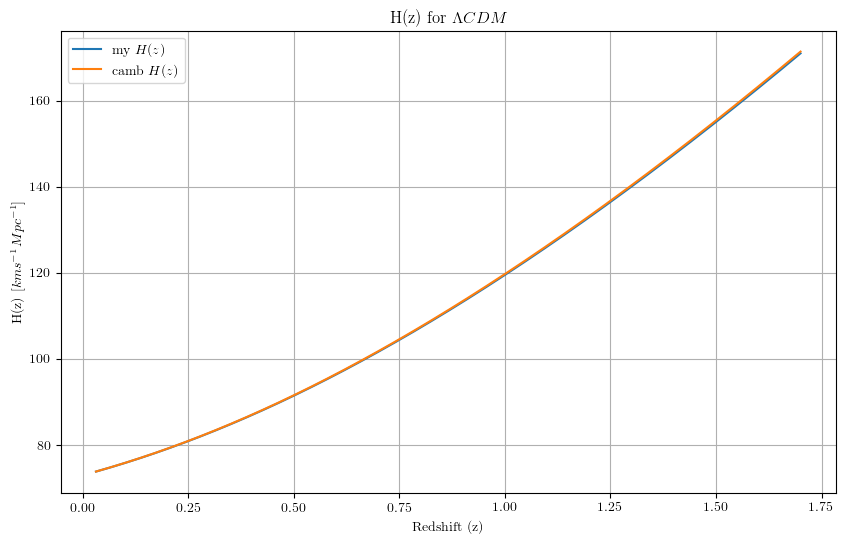

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator.hubble(zbins, zBinsFisher) , label=r'my $H(z)$')
plt.plot(zBinsFisher, cambhub, label=r'camb $H(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'H(z) $[km s^{-1} Mpc^{-1}]$')
plt.title(r'H(z) for $\Lambda CDM$')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

- **Check that $\mathbf{d_L(z)}$ agrees with $\mathbf{\Lambda CDM}$ from CAMB**

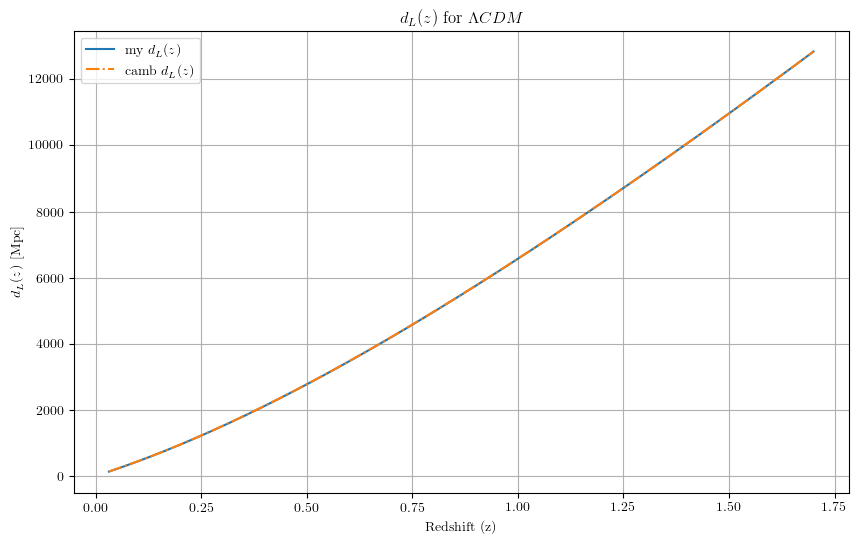

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
plt.plot(zBinsFisher, camblum, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
plt.legend()
plt.grid(True)
plt.show()

# Completness Tests

- First we need to project the dynamic DE model on the PCs that we have. For the purposes of this calculation, we will assume a specific form for our DE EoS, namely
  
  $ w(z) = w_0 + w_a (1 - a) \Rightarrow w(z) = w_0 + w_a ( \frac{z}{1+z})$ with $w_0=-0.827 \pm 0.063$ and $w_a = -0.75^{+0.29}_{-0.25}$ 
  
  (ref: https://data.desi.lbl.gov/public/papers/y1/DESI2024_VI_BAO_COSMOLOGY.pdf eq 5.6).

In [9]:
def dyn_w(z, w0, wa):
    return w0 + wa *( z / (1 + z))
dyn_w_list = [dyn_w(z, -0.827, -0.75) for z in zBinsFisher]
dyn_w_array = np.array(dyn_w_list)

In [10]:
def calculate_alphasQ(dyn_w_array, eigenvectors, Nx):
    alphasQ = []
    for i in range(Nx):
        a = np.sum((dyn_w_array + 1) * eigenvectors[i][:])
        alphasQ.append(a)
    return np.array(alphasQ)
    
alphasQ = calculate_alphasQ(dyn_w_array, eigenvectors, Nx)


- In the plot below we are comparing the reconstruction of the EoS using all $N_{z,PC}$ PCs compared to the analytical expression.

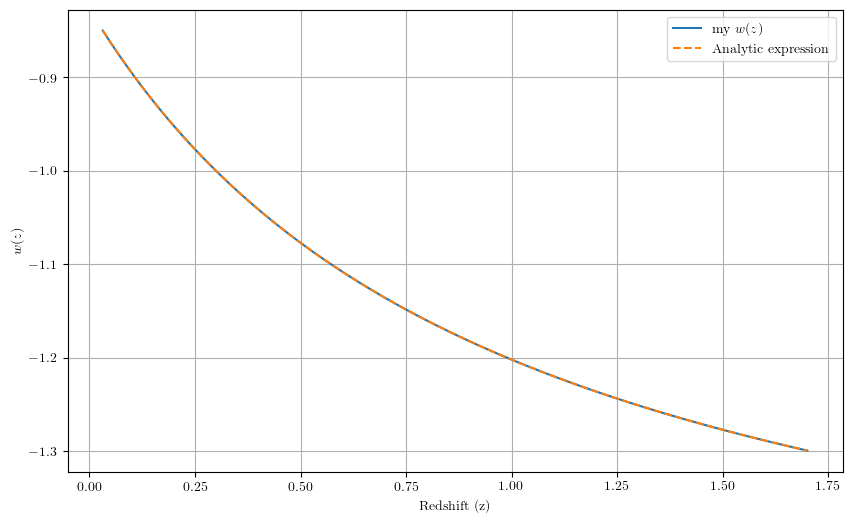

In [11]:
calculatorNx = CosmologyCalculatorPC(73, 0.24, 0, alphasQ, eigenvectors)
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatorNx.w(), label=r'my $w(z)$')
plt.plot(zBinsFisher, dyn_w_list, linestyle='--', label=r'Analytic expression')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$w(z)$ ')
plt.legend()
plt.grid(True)
plt.show()

#### Define comparison method and plot it for different choices of PCs

Define a comparing criterion between my PC functions and the camb answer

**Note that this criterion function ONLY works if I want to compare at the same $H_0$ values**

In [12]:
# This function will take as input the 5 * log(H0 d_L) and will return the chi squared as defined in equation A6 of 0810.1744
def criterion(f_pc, f_exp, sigma_sq):
    ''' All the inputs are numpy arrays '''
    return (f_exp - f_pc ) ** 2 / sigma_sq

- \% fractional difference for $w(z)$

In [13]:
def frac_dif(w_pc, w_exp):
    return ((w_pc - w_exp)/ (w_exp)) * 100
    

- Define the $\sigma$ as shown in equation A2 from 0810.1744

- Note that using the uncertainty calculated in the cell below along with the criterion as define in the previous cell, we basically end up getting equation A6 from 0810.1744, when I use it for the log of $d_L$ 

In [14]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0 ]
zSN = [0.03, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75 ]

dz1 = 0.1
dz2 = 0.07
tmp = zBinsFisher[1] - zBinsFisher[0]
fnSN = np.interp(zBinsFisher, zSN, NSN)
sigma2SNfisher = []

for i, z in enumerate(zBinsFisher):
    if z < 0.1:
        dz = dz2
    else:
        dz = dz1
    
    sigma2SNfisher.append(
        dz / tmp * (0.15**2 / fnSN[i] + 0.02**2 * ((1 + z) / 2.7)**2)
    )

sigma2SNfisher = np.array(sigma2SNfisher)

In [15]:
calculatorNx = CosmologyCalculatorPC(73, 0.24, 0, alphasQ, eigenvectors)
calculator1 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:1], eigenvectors[:1])
calculator5 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:5], eigenvectors[:5])
calculator10 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:10], eigenvectors[:10])
calculator50 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:50], eigenvectors[:50])
calculator100 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:100], eigenvectors[:100])
calculator150 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:150], eigenvectors[:150])
calculator30 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:30], eigenvectors[:30])
calculator20 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:20], eigenvectors[:20])
calculator15 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:15], eigenvectors[:15])



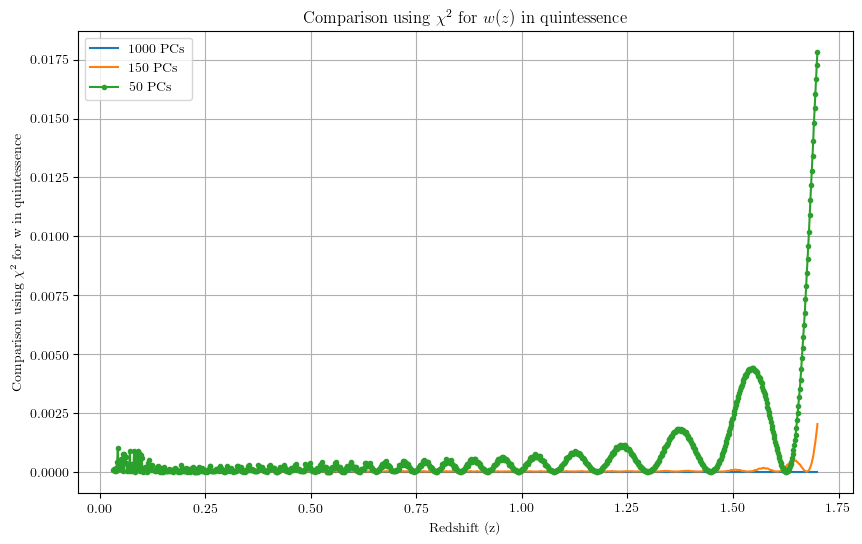

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(calculatorNx.w(), dyn_w_array, sigma2SNfisher) , label=rf'{Nx} PCs')
plt.plot(zBinsFisher, criterion(calculator150.w(), dyn_w_array, sigma2SNfisher) , label=r'150 PCs')
plt.plot(zBinsFisher, criterion(calculator50.w(), dyn_w_array, sigma2SNfisher) ,marker = '.', label=r'50 PCs')



#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'Comparison using $\chi^2$ for w in quintessence')
plt.title(r' Comparison using $\chi^2$ for $w(z)$ in quintessence')
plt.legend()
plt.grid(True)
plt.show()

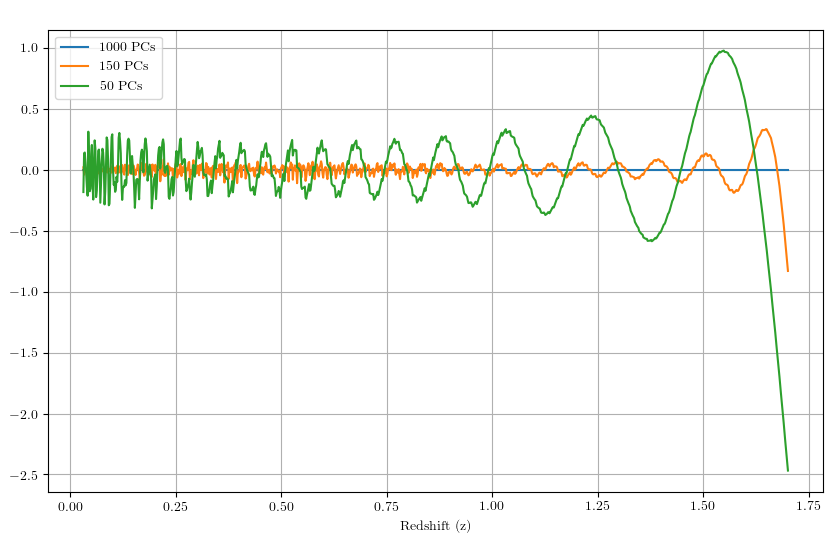

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, frac_dif(calculatorNx.w(), dyn_w_array) ,  label=rf'{Nx} PCs')
plt.plot(zBinsFisher, frac_dif(calculator150.w(), dyn_w_array) , label=r'150 PCs')
plt.plot(zBinsFisher, frac_dif(calculator50.w(), dyn_w_array) , label=r'50 PCs')
# plt.plot(zBinsFisher, calculator10.lum_distance(zbins, zBinsFisher) , label=r'10 PCs')
# plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'50 PCs')
# plt.plot(zBinsFisher, calculator100.lum_distance(zbins, zBinsFisher) , label=r'100 PCs')
# plt.plot(zBinsFisher, calculator150.lum_distance(zbins, zBinsFisher) , label=r'150 PCs')


#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'% Fractional Difference for w in quintessence')
plt.title(r' % Fractional Difference for $w(z)$ in quintessence')
plt.legend()
plt.grid(True)
plt.show()

- As expected when we reduce the number of PCs that we use, the $\chi^2$ for the EoS $w(z)$ gets modified significantly. We will now check what happens for the luminosity distance -- for which we expect results won't be as dramatic.

#### $\chi^2$ for $d_L(z)$

- I need to setup camb with the changed DE EoS so that I can compare my results with it.

In [18]:
from camb.dark_energy import DarkEnergyPPF
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)

pars.DarkEnergy = DarkEnergyPPF(w=-0.827, wa=-0.75)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [19]:
dyn_w_dl_array = [results.luminosity_distance(z) for z in zBinsFisher]

## Define the logarithm of the luminosity distance to use later

cmag = 149896229 / 500  # Speed of light in km/s/Mpc
logH0_dl_array = np.log10( (73 / cmag) * np.array(dyn_w_dl_array))

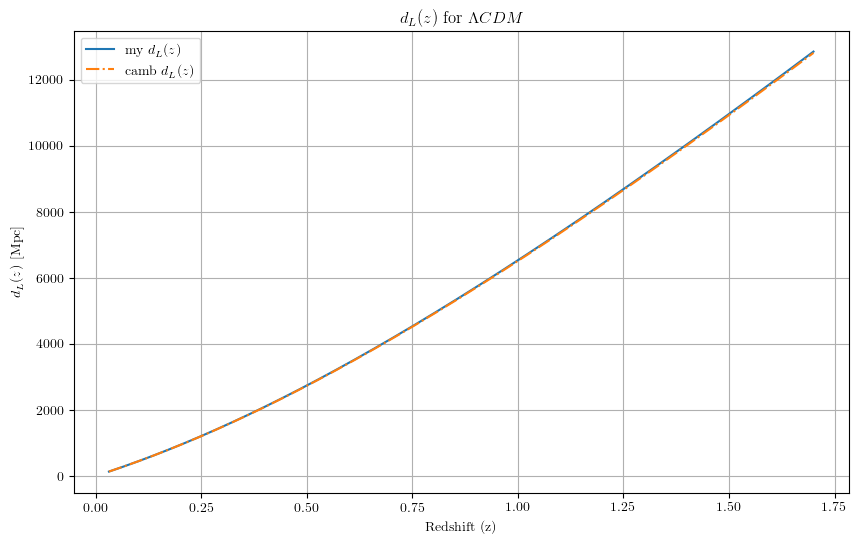

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatorNx.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, dyn_w_dl_array, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

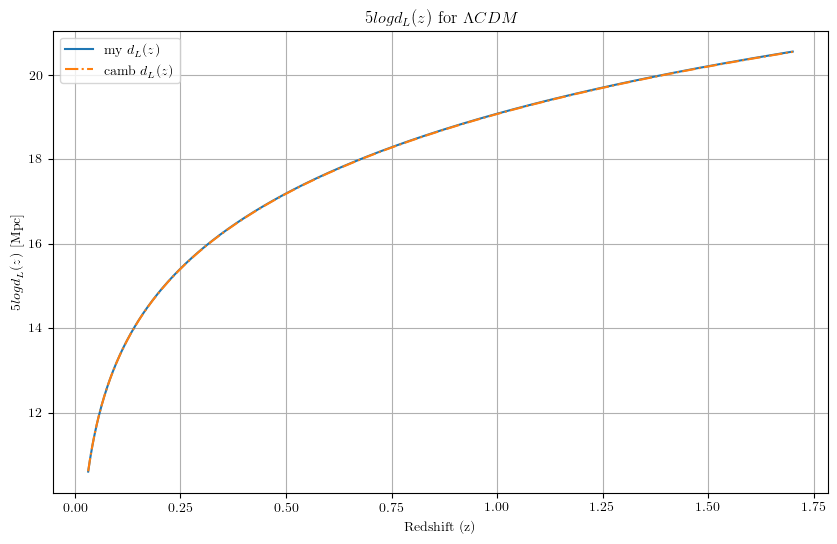

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, 5*np.log10(calculatorNx.lum_distance(zbins, zBinsFisher)), label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, 5*np.log10(dyn_w_dl_array), linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$5logd_L(z)$ [Mpc]')
plt.title(r'$5logd_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

- It seems that with 50 PCs I do exceptionally well in terms of the $\chi^2$.
- With 20 PCs, I am still close but visibly different than 500 PCs, especially for the larger values of z. This behavior in the high z values is expected because I have ignored a lot of high PCs.

- In order to compare and figure out how many PCs I need for the completeness of my basis, I need to compare the average magnitudes I get from my PC reconstruction vs the CAMB output. 

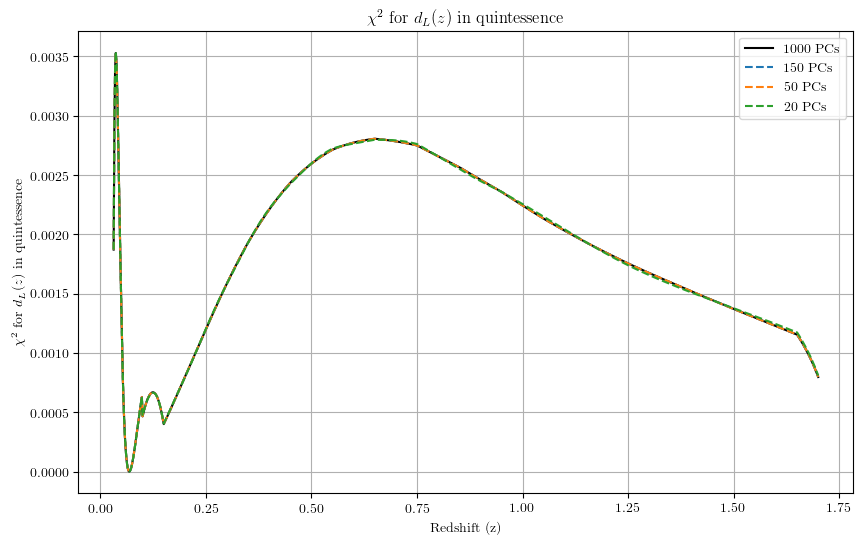

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(5*calculatorNx.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array , sigma2SNfisher), color='black', label=rf'{Nx} PCs')
plt.plot(zBinsFisher, criterion(5*calculator150.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array, sigma2SNfisher) , linestyle='--', label=r'150 PCs')

plt.plot(zBinsFisher, criterion(5*calculator50.logH0lum_distance(zbins, zBinsFisher) , 5*logH0_dl_array, sigma2SNfisher),linestyle='--', label=r'50 PCs')

plt.plot(zBinsFisher, criterion(5*calculator20.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array, sigma2SNfisher ), linestyle='--', label=r'20 PCs')

#plt.plot(zBinsFisher, criterion(5*calculator10.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array, sigma2SNfisher ), linestyle=':', color='C0',label=r'10 PCs')



#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\chi^2$ for $d_L(z)$ in quintessence')
plt.title(r'$\chi^2$ for $d_L(z)$ in quintessence')
# plt.xlim(1.5, 1.7)
# plt.ylim(0.0010,0.0014)
plt.legend()
plt.grid(True)
plt.show()

## Trial plots for different choices of cosmological parameters

In [22]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=70.990658, ombh2= (0.297321 * 70.990658**2 * 0.2)/10e4 , omch2=(0.297321 * 70.990658**2 * 0.8)/10e4, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)

pars.DarkEnergy = DarkEnergyPPF(w=-0.827, wa=-0.75)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

dyn_w_dl_array = [results.luminosity_distance(z) for z in zBinsFisher]

## Define the logarithm of the luminosity distance to use later

cmag = 149896229 / 500  # Speed of light in km/s/Mpc
logH0_dl_array = np.log10( (70.990658/ cmag) * np.array(dyn_w_dl_array))

calculatortest = CosmologyCalculatorPC(70.990658, 0.297321, 0, alphasQ, eigenvectors)

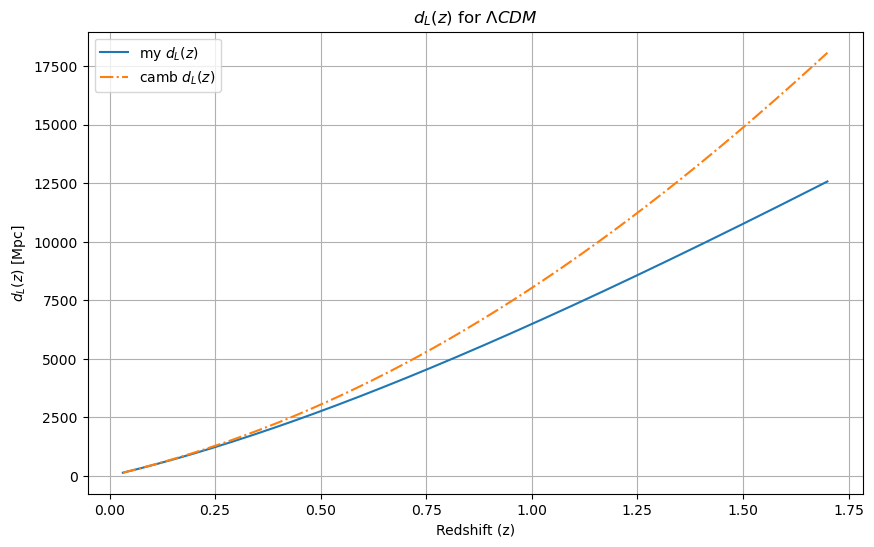

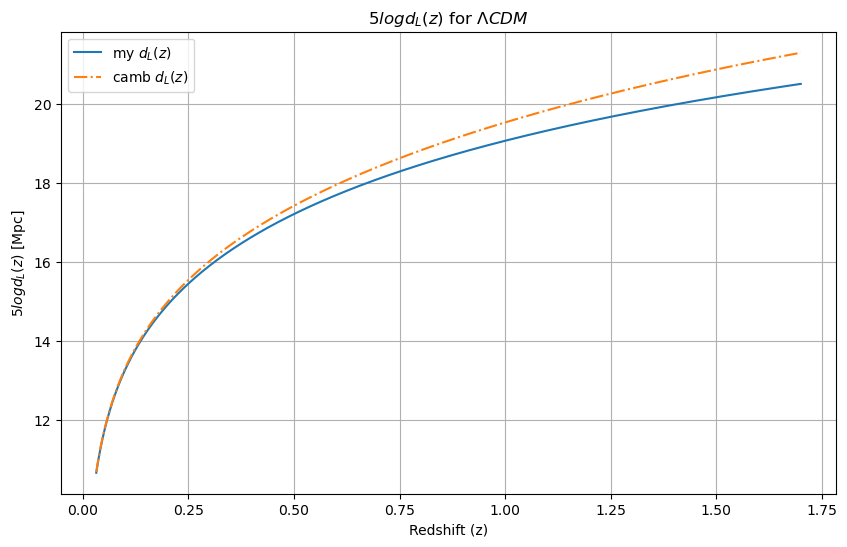

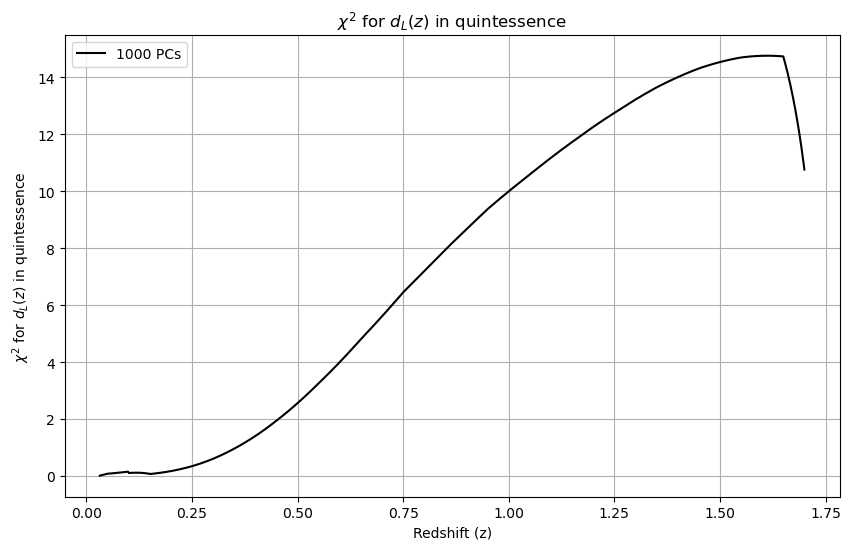

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatortest.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, dyn_w_dl_array, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, 5*np.log10(calculatortest.lum_distance(zbins, zBinsFisher)), label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, 5*np.log10(dyn_w_dl_array), linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$5logd_L(z)$ [Mpc]')
plt.title(r'$5logd_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(5*calculatortest.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array , sigma2SNfisher), color='black', label=rf'{Nx} PCs')
#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\chi^2$ for $d_L(z)$ in quintessence')
plt.title(r'$\chi^2$ for $d_L(z)$ in quintessence')
# plt.xlim(1.5, 1.7)
# plt.ylim(0.0010,0.0014)
plt.legend()
plt.grid(True)
plt.show()


## Trial plots for varying parameters of the smooth DE EoS

In [24]:
dyn_w_list = [dyn_w(z, -0.9, -0.6) for z in zBinsFisher]
dyn_w_array = np.array(dyn_w_list)
alphasQtest = calculate_alphasQ(dyn_w_array, eigenvectors, Nx)

In [25]:
from camb.dark_energy import DarkEnergyPPF
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)

pars.DarkEnergy = DarkEnergyPPF(w=-0.9, wa=-0.6)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

dyn_w_dl_array = [results.luminosity_distance(z) for z in zBinsFisher]

## Define the logarithm of the luminosity distance to use later

cmag = 149896229 / 500  # Speed of light in km/s/Mpc
logH0_dl_array = np.log10( (73 / cmag) * np.array(dyn_w_dl_array))
calculatortest = CosmologyCalculatorPC(73, 0.24, 0, alphasQtest, eigenvectors)


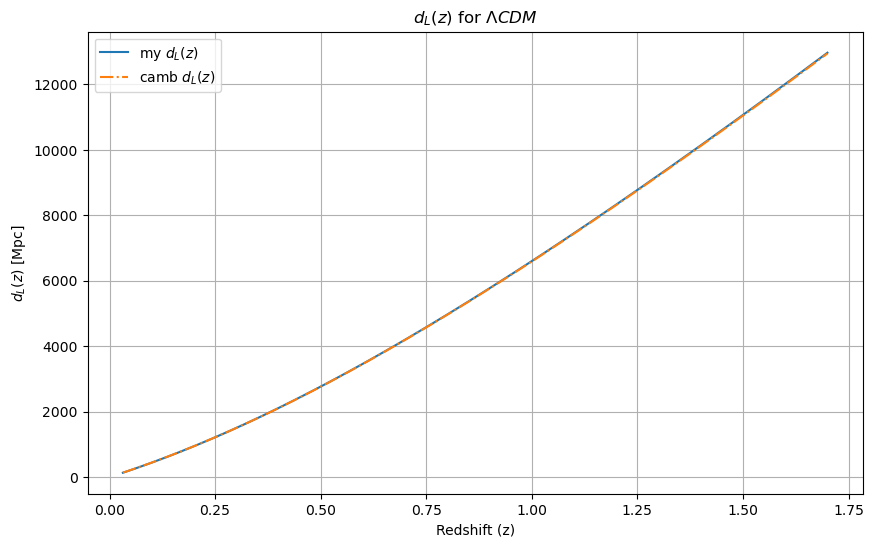

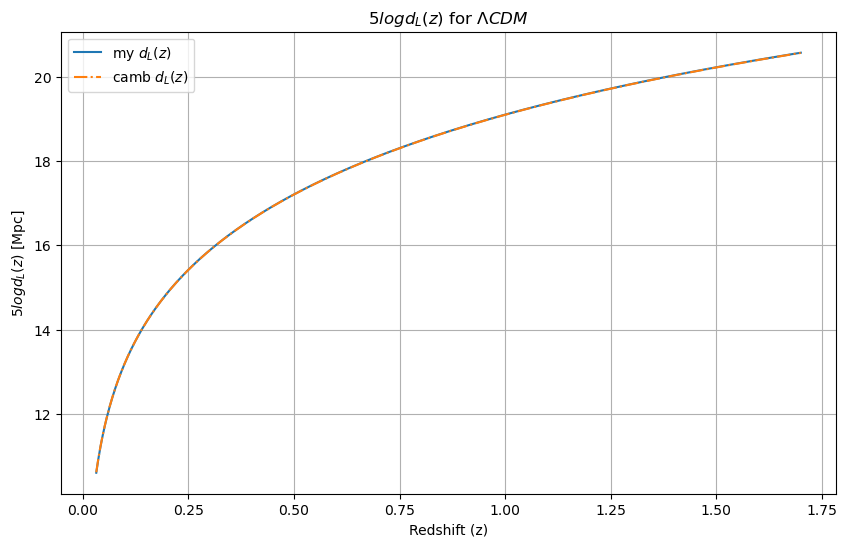

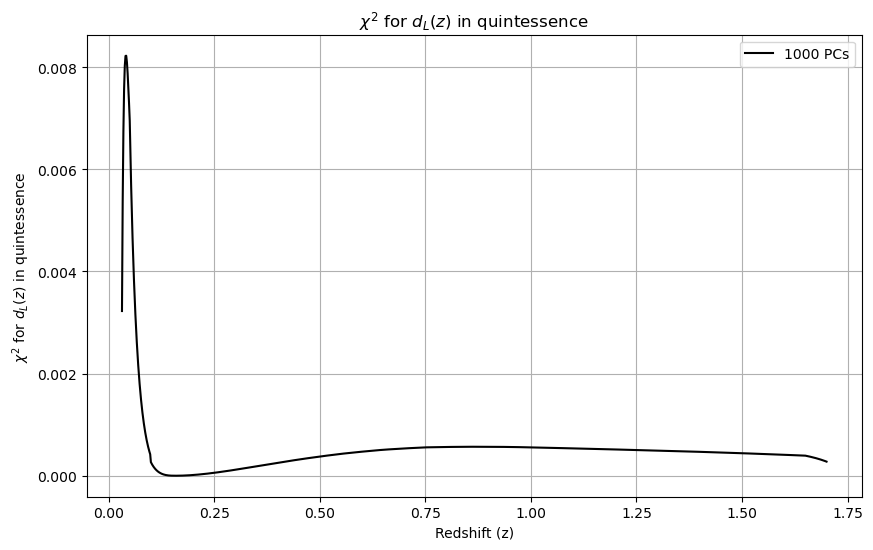

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatortest.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, dyn_w_dl_array, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, 5*np.log10(calculatortest.lum_distance(zbins, zBinsFisher)), label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, 5*np.log10(dyn_w_dl_array), linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$5logd_L(z)$ [Mpc]')
plt.title(r'$5logd_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(5*calculatortest.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array , sigma2SNfisher), color='black', label=rf'{Nx} PCs')
#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\chi^2$ for $d_L(z)$ in quintessence')
plt.title(r'$\chi^2$ for $d_L(z)$ in quintessence')
# plt.xlim(1.5, 1.7)
# plt.ylim(0.0010,0.0014)
plt.legend()
plt.grid(True)
plt.show()

## Heatmap of $\chi^2$ for varying cosmological parameters and fixed $w(z)$ EoS

In [27]:
def compute_chisq(cosmo_params):
    ombh2 = 0.2 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000
    omch2 = 0.8 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000

    # Run CAMB for this choice of parameters
    pars.set_cosmology(H0=cosmo_params[0], ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(ns=0.956, r=0)
    pars.DarkEnergy = DarkEnergyPPF(w=-0.827, wa=-0.75)
    pars.set_for_lmax(2000, lens_potential_accuracy=1)
    results = camb.get_results(pars)

    # Run my method for the same cosmological parameters
    calculator = CosmologyCalculatorPC(cosmo_params[0], cosmo_params[1], 0, alphasQ, eigenvectors)
    
    # Calculate the luminosity distances for the two methods
    camblum = [5 * np.log10((cosmo_params[0] / cmag) * np.array(results.luminosity_distance(z))) for z in zBinsFisher]
    mydL = 5 * calculator.logH0lum_distance(zbins, zBinsFisher)
    
    # Compare the distances and get a chi^2
    chisq = np.sum(criterion(mydL, camblum , sigma2SNfisher))
    
    return cosmo_params[0], cosmo_params[1], chisq

# Start the timer
start_time = time.time()

# Parallelize the loop using joblib
n_jobs = -1  # Use all available CPU cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_chisq)(np.random.uniform(low=[67, 0.2], high=[74, 0.32])) for _ in range(200))

# Store results in a DataFrame
chisq_df1 = pd.DataFrame(results, columns=['H0', 'Om', 'chisq'])

# End the timer
end_time = time.time()

# Print the total execution time
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")
chisq_df1 = pd.DataFrame(results, columns=['H0', 'Om', 'chisq'])


Total execution time: 232.80 seconds


In [28]:
chisq_df1.head()

,H0,Om,chisq
0,73.341851,0.254167,1.686648
1,70.913467,0.253886,1.747163
2,67.996898,0.218168,2.325169
3,72.916783,0.224970,2.072927
4,67.221891,0.206735,2.540323


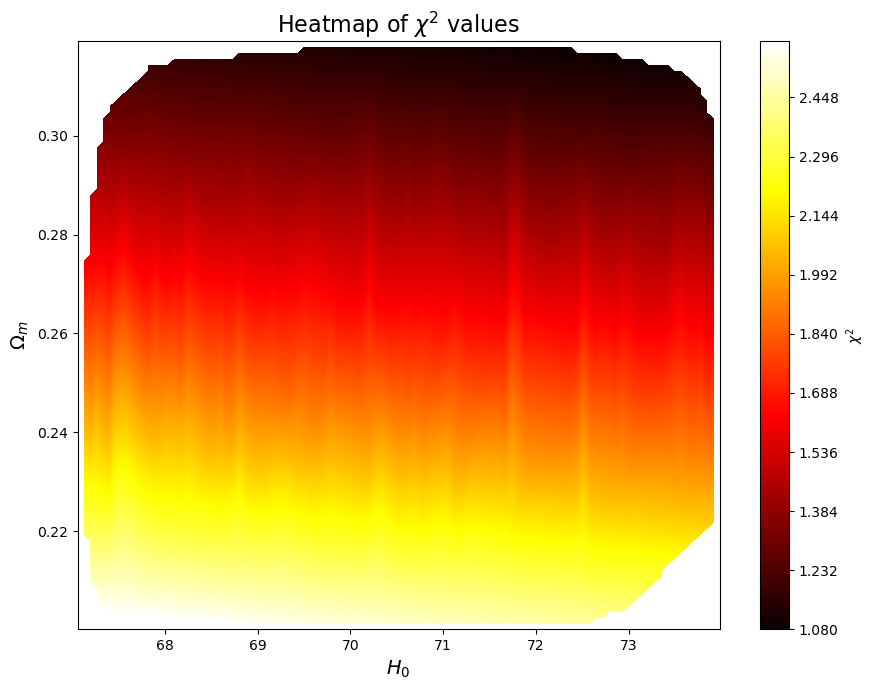

In [29]:
# Extract data from the DataFrame
H0_vals = chisq_df1['H0'].values
Om_vals = chisq_df1['Om'].values
chisq_vals = chisq_df1['chisq'].values

# Create grid data for interpolation
grid_x, grid_y = np.mgrid[H0_vals.min():H0_vals.max():100j, Om_vals.min():Om_vals.max():100j]

# Interpolate the chi-squared values on the grid
grid_z = griddata((H0_vals, Om_vals), chisq_vals, (grid_x, grid_y), method='linear')

# Plot the contour plot
plt.figure(figsize=(9, 7))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=200, cmap='hot')

# Add a colorbar with label
plt.colorbar(contour, label=r'$\chi^2$')

# Set axis labels and title
plt.xlabel(r'$H_0$', fontsize=14)
plt.ylabel(r'$\Omega_m$', fontsize=14)
plt.title(r'Heatmap of $\chi^2$ values', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


## Heatmap of $\chi^2$ for fixed cosmological parameters and varying $w(z)$ EoS -- Using ALL the PCs available

In [24]:
def compute_chisq_dyn(w0, wa, cosmo_params, NPC):
    dynw = [dyn_w(z, w0, wa) for z in zBinsFisher]
    dyn_w_arr = np.array(dynw)
    alphas_proj = calculate_alphasQ(dyn_w_arr, eigenvectors, Nx)
    ombh2 = 0.2 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000
    omch2 = 0.8 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000
    
    # Run CAMB for this choice of parameters
    pars.set_cosmology(H0=cosmo_params[0], ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(ns=0.956, r=0)
    pars.DarkEnergy = DarkEnergyPPF(w=w0, wa=wa)
    pars.set_for_lmax(2000, lens_potential_accuracy=1)
    results = camb.get_results(pars)

    # Run my method for the same cosmological parameters and the chosen number of PCs
    if NPC == None:
        calc = CosmologyCalculatorPC(cosmo_params[0], cosmo_params[1], 0, alphas_proj, eigenvectors)
    else:
        calc = CosmologyCalculatorPC(cosmo_params[0], cosmo_params[1], 0, alphas_proj[:NPC], eigenvectors[:NPC])
    
    # Calculate the luminosity distances for the two methods
    camblum = [5 * np.log10((cosmo_params[0] / cmag) * np.array(results.luminosity_distance(z))) for z in zBinsFisher]
    mydL = 5 * calc.logH0lum_distance(zbins, zBinsFisher)
    
    # Compare the distances and get a chi^2
    chisq = np.sum(criterion(mydL, camblum, sigma2SNfisher))
    
    return w0, wa, chisq

In [31]:
# Start the timer
start_time = time.time()

# Parallelize the loop using joblib
n_jobs = -1  # Use all available CPU cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_chisq_dyn)(*np.random.uniform(low=[-1,-1.5 ], high=[-0.2, -0.6]), [73, 0.24], None) for _ in range(200))

# Store results in a DataFrame
chisq_df = pd.DataFrame(results, columns=['w0', 'wa', 'chisq'])

# End the timer
end_time = time.time()

# Print the total execution time
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")
chisq_df = pd.DataFrame(results, columns=['w0', 'wa', 'chisq'])

Total execution time: 233.93 seconds


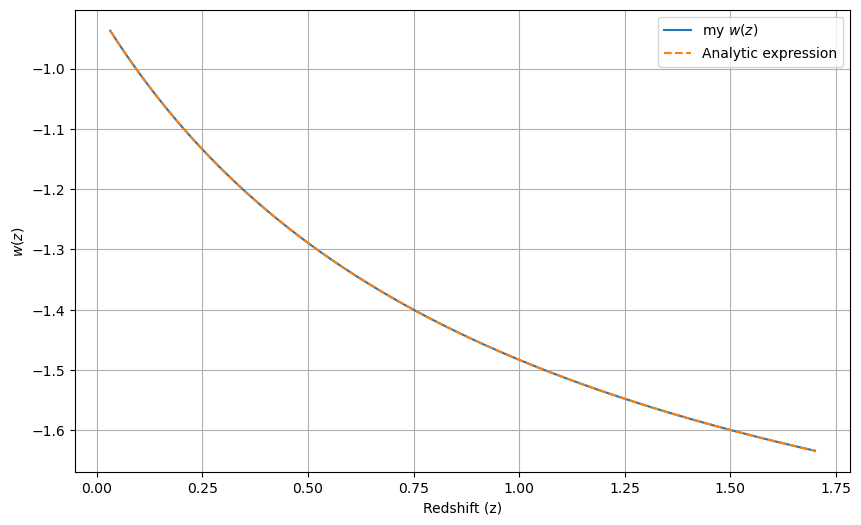

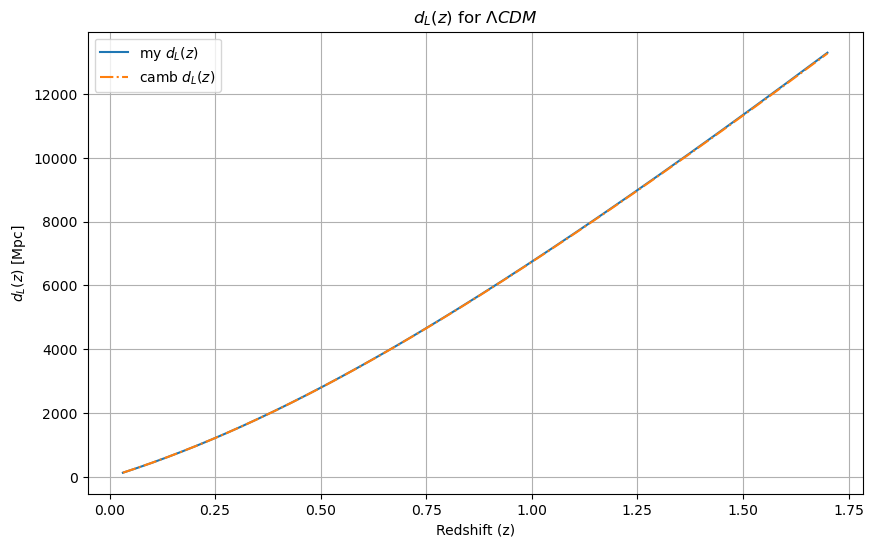

0.5006521089987279

In [87]:
a = -0.901288
b = -1.163562
z = np.linspace(0, 1.7, 100) 
w = a + b *( z / (1 + z))

# plt.plot(z, w, label=f'w = {a} + {b}*a')
# plt.xlabel('z')
# plt.ylabel('w')
# plt.title('Plot of w(z) EoS')
# plt.legend()
# plt.grid(True)
# plt.show()

dyn_w_list_1 = [dyn_w(z, a, b) for z in zBinsFisher]
dyn_w_array_1 = np.array(dyn_w_list_1)
alphasQ_1 = calculate_alphasQ(dyn_w_array_1, eigenvectors, Nx)

calculatorNx_1 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ_1, eigenvectors)
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatorNx_1.w(), label=r'my $w(z)$')
plt.plot(zBinsFisher, dyn_w_list_1, linestyle='--', label=r'Analytic expression')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$w(z)$ ')
plt.legend()
plt.grid(True)
plt.show()

from camb.dark_energy import DarkEnergyPPF
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)

pars.DarkEnergy = DarkEnergyPPF(w=-0.901288, wa=-1.163562)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

dyn_w_dl_array_1 = [results.luminosity_distance(z) for z in zBinsFisher]

## Define the logarithm of the luminosity distance to use later

cmag = 149896229 / 500  # Speed of light in km/s/Mpc
logH0_dl_array = np.log10( (73 / cmag) * np.array(dyn_w_dl_array_1))

plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculatorNx_1.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, dyn_w_dl_array_1, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

# Compare the distances and get a chi^2
np.sum(criterion( [5 * np.log10((73 / cmag) * np.array(results.luminosity_distance(z))) for z in zBinsFisher], 5 * calculatorNx_1.logH0lum_distance(zbins, zBinsFisher), sigma2SNfisher))



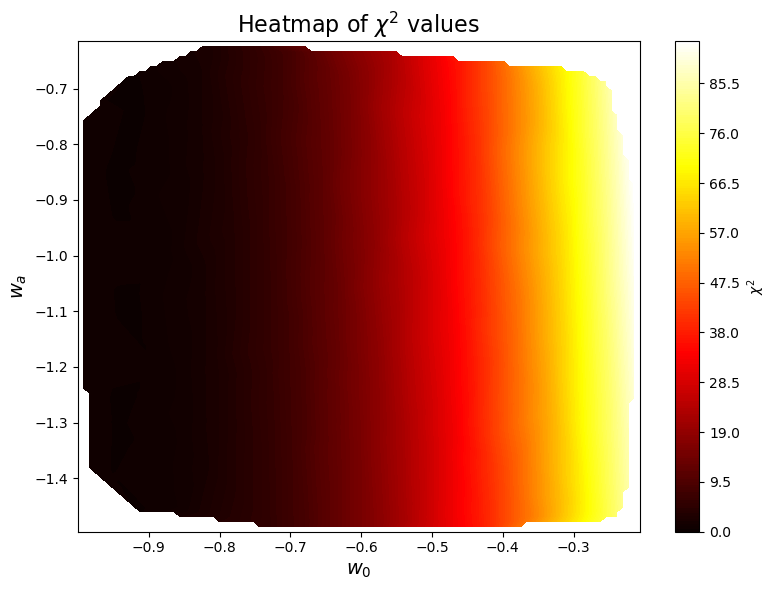

In [32]:
# Extract data from the DataFrame
w0_vals = chisq_df['w0'].values
wa_vals = chisq_df['wa'].values
chisq_vals = chisq_df['chisq'].values

# Create grid data for interpolation
grid_x, grid_y = np.mgrid[w0_vals.min():w0_vals.max():100j, wa_vals.min():wa_vals.max():100j]

# Interpolate the chi-squared values on the grid
grid_z = griddata((w0_vals, wa_vals), chisq_vals, (grid_x, grid_y), method='linear')

# Plot the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=200, cmap='hot')

# Add a colorbar with label
plt.colorbar(contour, label=r'$\chi^2$')

# Set axis labels and title
plt.xlabel(r'$w_0$', fontsize=14)
plt.ylabel(r'$w_a$', fontsize=14)
plt.title(r'Heatmap of $\chi^2$ values', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

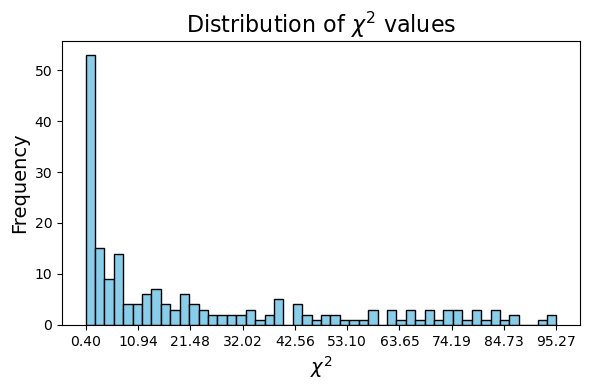

Histogram bin edges: [ 0.39927643  2.29665025  4.19402407  6.09139789  7.98877171  9.88614553
 11.78351935 13.68089317 15.57826699 17.47564081 19.37301463 21.27038845
 23.16776227 25.06513609 26.96250991 28.85988373 30.75725755 32.65463137
 34.55200519 36.44937901 38.34675283 40.24412665 42.14150047 44.03887429
 45.9362481  47.83362192 49.73099574 51.62836956 53.52574338 55.4231172
 57.32049102 59.21786484 61.11523866 63.01261248 64.9099863  66.80736012
 68.70473394 70.60210776 72.49948158 74.3968554  76.29422922 78.19160304
 80.08897686 81.98635068 83.8837245  85.78109832 87.67847214 89.57584596
 91.47321978 93.3705936  95.26796742]


In [33]:
# Extract data from the DataFrame
w0_vals = chisq_df['w0'].values
wa_vals = chisq_df['wa'].values
chisq_vals = chisq_df['chisq'].values

# Task 1: Distribution of chi^2 values
plt.figure(figsize=(6, 4))
n, bins, patches = plt.hist(chisq_vals, bins=50, color='skyblue', edgecolor='black')
plt.xticks(np.linspace(chisq_vals.min(), chisq_vals.max(), 10))
plt.xlabel(r'$\chi^2$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of $\chi^2$ values', fontsize=16)
plt.tight_layout()
plt.show()

# Print the limits of the histogram bins
print("Histogram bin edges:", bins)


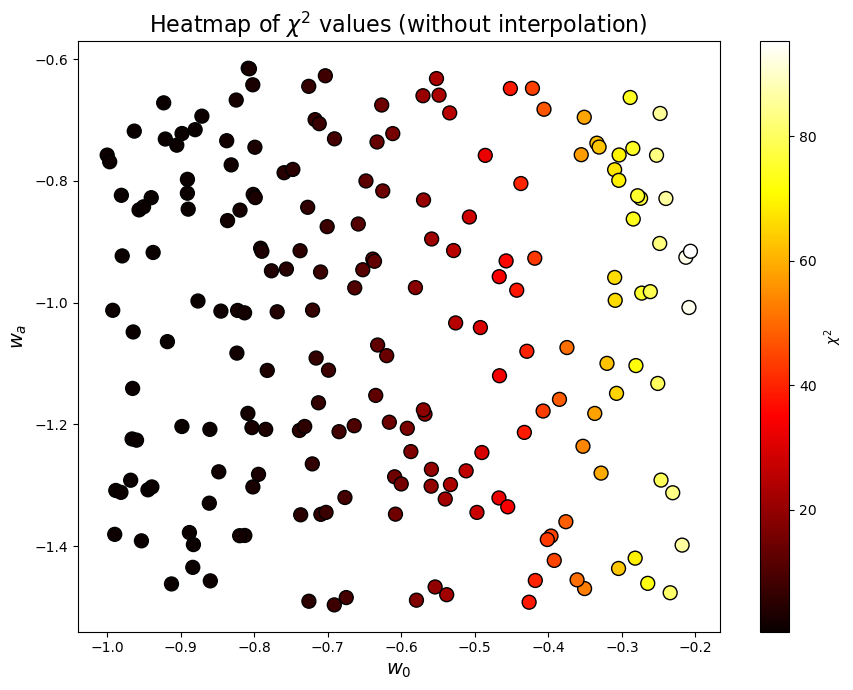

In [34]:
# Remake the heat map without interpolation
plt.figure(figsize=(9, 7))
scatter = plt.scatter(w0_vals, wa_vals, c=chisq_vals, cmap='hot', s=100, edgecolor='k')
plt.colorbar(scatter, label=r'$\chi^2$')

plt.xlabel(r'$w_0$', fontsize=14)
plt.ylabel(r'$w_a$', fontsize=14)
plt.title(r'Heatmap of $\chi^2$ values (without interpolation)', fontsize=16)

plt.tight_layout()
plt.show()

## Heatmap of $\chi^2$ for fixed cosmological parameters and varying $w(z)$ EoS -- Completness tests

In [25]:
# Start the timer
start_time = time.time()

# Parallelize the loop using joblib
n_jobs = -1  # Use all available CPU cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_chisq_dyn)(*np.random.uniform(low=[-1,-1.5 ], high=[-0.6, -0.6]), [73, 0.24], 150) for _ in range(500))

# Store results in a DataFrame
chisq_df_NPC = pd.DataFrame(results, columns=['w0', 'wa', 'chisq'])

# End the timer
end_time = time.time()

# Print the total execution time
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")
chisq_df_NPC = pd.DataFrame(results, columns=['w0', 'wa', 'chisq'])

Total execution time: 602.83 seconds


In [26]:
# Extract data from the DataFrame
w0_vals = chisq_df_NPC['w0'].values
wa_vals = chisq_df_NPC['wa'].values
chisq_vals = chisq_df_NPC['chisq'].values

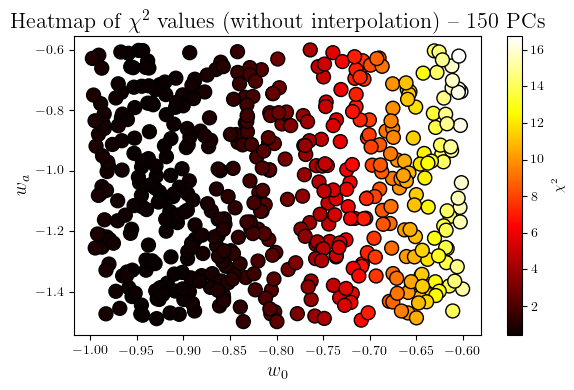

In [27]:
# Remake the heat map without interpolation
plt.figure(figsize=(6, 4))
scatter = plt.scatter(w0_vals, wa_vals, c=chisq_vals, cmap='hot', s=100, edgecolor='k')
plt.colorbar(scatter, label=r'$\chi^2$')

plt.xlabel(r'$w_0$', fontsize=14)
plt.ylabel(r'$w_a$', fontsize=14)
plt.title(r'Heatmap of $\chi^2$ values (without interpolation) -- 150 PCs', fontsize=16)

plt.tight_layout()
plt.show()

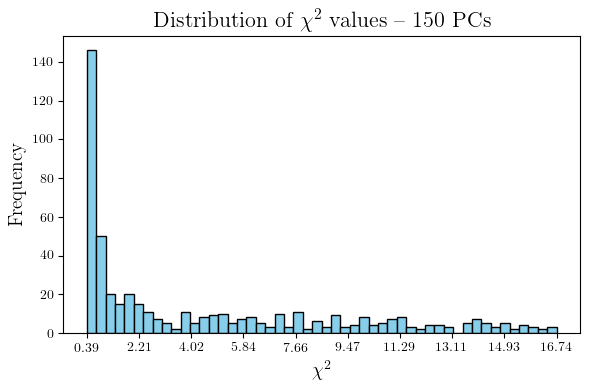

Histogram bin edges: [ 0.38792102  0.71500646  1.0420919   1.36917734  1.69626278  2.02334821
  2.35043365  2.67751909  3.00460453  3.33168997  3.6587754   3.98586084
  4.31294628  4.64003172  4.96711716  5.29420259  5.62128803  5.94837347
  6.27545891  6.60254435  6.92962978  7.25671522  7.58380066  7.9108861
  8.23797154  8.56505698  8.89214241  9.21922785  9.54631329  9.87339873
 10.20048417 10.5275696  10.85465504 11.18174048 11.50882592 11.83591136
 12.16299679 12.49008223 12.81716767 13.14425311 13.47133855 13.79842398
 14.12550942 14.45259486 14.7796803  15.10676574 15.43385117 15.76093661
 16.08802205 16.41510749 16.74219293]


In [28]:
# Distribution of chi^2 values
plt.figure(figsize=(6, 4))
n, bins, patches = plt.hist(chisq_vals, bins=50, color='skyblue', edgecolor='black')
plt.xticks(np.linspace(chisq_vals.min(), chisq_vals.max(), 10))
plt.xlabel(r'$\chi^2$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of $\chi^2$ values -- 150 PCs', fontsize=16)
plt.tight_layout()
plt.show()

# limits of the histogram bins
print("Histogram bin edges:", bins)

### Compare the $\chi^2$ for different number of PCs keeping the cosmology fixed

In [52]:
# Start the timer
start_time = time.time()

# Parallelize the loop using joblib
n_jobs = -1  # Use all available CPU cores
results = Parallel(n_jobs=n_jobs)(
    delayed(lambda NPC: (*compute_chisq_dyn(-0.827, -0.75, [73, 0.24], NPC), NPC))(NPC) 
    for NPC in range(1,1001)
)

# Store results in a DataFrame, including NPC as a column
chisq_compare_NPC = pd.DataFrame(results, columns=['w0', 'wa', 'chisq', 'NPC'])

# End the timer
end_time = time.time()

# Print the total execution time
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")



Total execution time: 1199.32 seconds


- Looking at the follwoing plot, it seems that after $\sim 10$ PCs the reduction of $\chi^2$ is minimal.

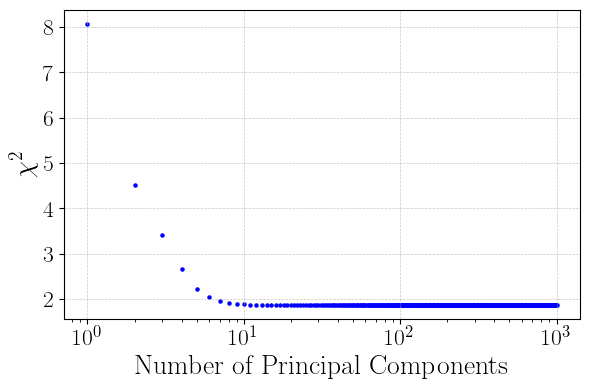

In [58]:
# Plotting chi-squared vs NPC

plt.figure(figsize=(6, 4))
plt.scatter(chisq_compare_NPC['NPC'], chisq_compare_NPC['chisq'], s=5, color='blue')
plt.xlabel('Number of Principal Components', fontsize=20, weight='bold')
plt.ylabel(r'$\chi^2$', fontsize=20, weight='bold')
plt.xscale('log')
#plt.yscale('log') 
#plt.title(r'$\chi^2$ vs Number of PC for $(w_0,w_a) = (-0.827, -0.75)$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=17, family='serif')
plt.yticks(fontsize=17, family='serif')
plt.tight_layout()
plt.savefig("/home/venus/cosmo_stuff/emul2024/artemis/chiSq_vs_number_of_PCs.pdf", format="pdf", bbox_inches="tight")
plt.show()